In [1]:
import copclib as copc
import os
import struct
import json
import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib widget

In [2]:
print(os.getcwd())

/data/Arbeit/mee


In [3]:
# Datei Einlesen:
# reader = copc.FileReader("/home/vlasi/Downloads/sofi.copc.laz")
reader = copc.FileReader("./daten/autzen.copc.laz")

# Copc Info und Las Header (für boxen)
copc_info = reader.copc_config.copc_info
las_header = reader.copc_config.las_header

# Bounding Box der Root node extrahieren: 

    # Root Voxelkey anlegen
root_key = copc.VoxelKey(0,0,0,0)

    # Root Entry (Node) laden (ohne Punkte)
root_node = reader.FindNode(root_key)

    # Bounding Box konstruieren aus VoxelKey und Las-Header
root_box = copc.Box(root_key, las_header)
print("Root Box:\n\txmin:{}\n\txmax:{}\n\n\tymin:{}\n\tymax:{}\n\n\tzmin:{}\n\tzmax:{}".format(root_box.x_min, root_box.x_max, root_box.y_min, root_box.y_max, root_box.z_min, root_box.z_max))


Root Box:
	xmin:635577.79
	xmax:640233.3

	ymin:848882.15
	ymax:853537.66

	zmin:406.14
	zmax:5061.65000000001


In [4]:
# Alle Nodes auslesen und Bounding Boxen konstruieren

all_entries = reader.GetAllNodes()
boxes = []

for entry in all_entries:
    boxes.append(copc.Box(entry.key, las_header))

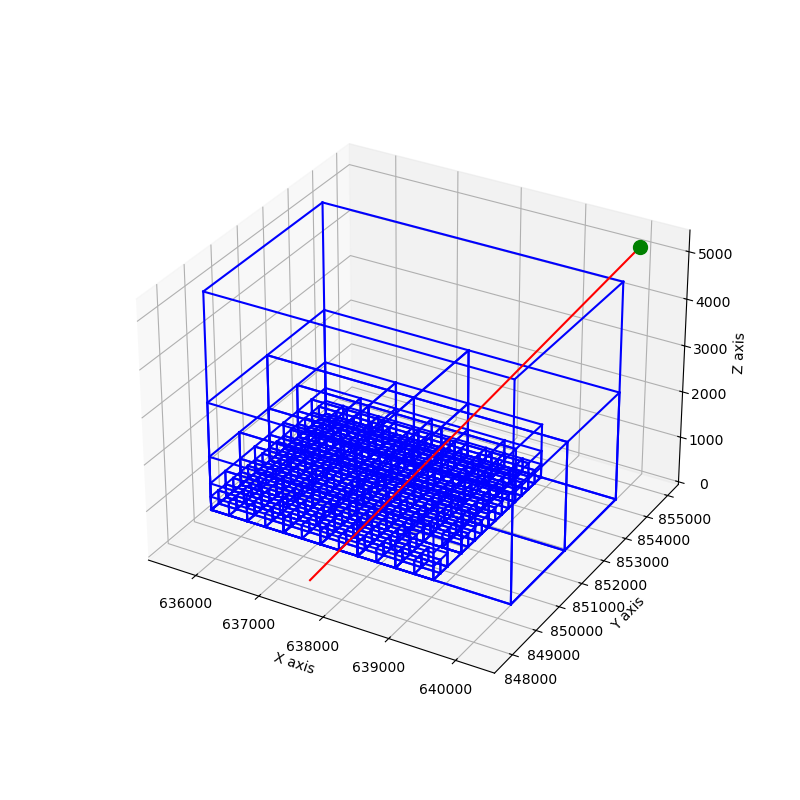

In [5]:
from visuals import draw_boxes
from ray import Ray

Strahl = Ray(np.array([640000, 855000, 5100]), np.array([-1, -3, -2]))

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

draw_boxes(boxes, ax)
Strahl.draw_ray(ax, 9000)

In [6]:
from ray import Ray
test = Ray(np.array([1,2,3]), np.array([1,2,3]))
test.richtung = np.array([5,5,5])
print(test)

Ray( Ursprung=[1 2 3], Richtung=[0.57735027 0.57735027 0.57735027])
